In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
xls_data=pd.read_excel("./table.xlsx")

In [3]:
t2_dat=xls_data.loc[:,"# of turns":"HFSS"]

In [4]:
t3_dat=xls_data.loc[:,"# of turns.1":"HFSS.1"]

In [5]:
t4_dat=xls_data.loc[:,"# of turns.2":"HFSS.2"]

In [6]:
t2_dat=t2_dat.replace(np.nan,0)
t3_dat=t3_dat.replace(np.nan,0)
t4_dat=t4_dat.replace(np.nan,0)

In [7]:
def data_restore(dat):
    for col_name in dat.columns[:5]:
        temp=0
        for i in range(len(dat[col_name])):
            if (dat.loc[i,col_name]!=0):
                temp=dat.loc[i,col_name]
            if (dat.loc[i,col_name]==0):
                dat.loc[i,col_name]=temp
    return dat

In [8]:
t2_dat=data_restore(t2_dat)
t3_dat=data_restore(t3_dat)
t4_dat=data_restore(t4_dat)

In [9]:
total_dat_temp=np.vstack([t2_dat.values, t3_dat.values,t4_dat.values])

In [10]:
del_index=np.where(total_dat_temp[:,6]==0)[0]

In [11]:
total_dat_temp=pd.DataFrame(total_dat_temp,columns=t2_dat.columns)

In [12]:
total_dat=total_dat_temp.drop(del_index)

In [13]:
total_dat.to_csv("preprocessed_data.csv",
                 columns=total_dat.columns,sep=",", index=False)

In [14]:
data=total_dat.values

In [15]:
log_dat_x=np.log(data[:,:6])

In [16]:
log_dat_y=np.log(data[:,6])

In [17]:
x_train=np.hstack([log_dat_x,data[:,:6]])

In [18]:
mean_x=np.mean(x_train, axis=0)
std_x=np.std(x_train, axis=0)

In [19]:
x_train=(x_train - mean_x) / std_x

In [20]:
mean_y=np.mean(log_dat_y)
std_y=np.std(log_dat_y)

In [21]:
y_train=(log_dat_y-mean_y)/std_y

In [22]:
x_train=torch.FloatTensor(x_train)
y_train=torch.FloatTensor(y_train)

In [23]:
model=nn.Linear(12,1)

In [24]:
print(list(model.parameters()))

[Parameter containing:
tensor([[ 0.1115,  0.0805, -0.0091,  0.1890, -0.1656,  0.1731, -0.0963,  0.0254,
         -0.0367,  0.2104,  0.1202,  0.2567]], requires_grad=True), Parameter containing:
tensor([-0.1780], requires_grad=True)]


In [25]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

In [26]:
import time
nb_epochs = 100
start = time.time()
for epoch in range(nb_epochs+1):

    prediction = torch.squeeze(model(x_train))
    cost = F.mse_loss(prediction, y_train) 
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          epoch, nb_epochs, cost.item()
      ))
print("time:{:.6f} s".format(time.time()-start))

Epoch    0/100 Cost: 2.131928
Epoch  100/100 Cost: 0.017448
time:0.077862 s


In [27]:
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.0370, -0.1522,  0.0549,  0.0087, -0.1488, -1.0012, -0.1944,  0.0304,
          0.0273,  0.0300,  0.0205,  0.0568]], requires_grad=True), Parameter containing:
tensor([-1.0683e-08], requires_grad=True)]


In [28]:
x=np.squeeze(model(x_train).detach().numpy())

In [29]:
y=y_train.detach().numpy()

In [30]:
x.shape

(468,)

In [31]:
y.shape

(468,)

MSE: 0.017448117956519127
RMSE: 0.1320913243045096


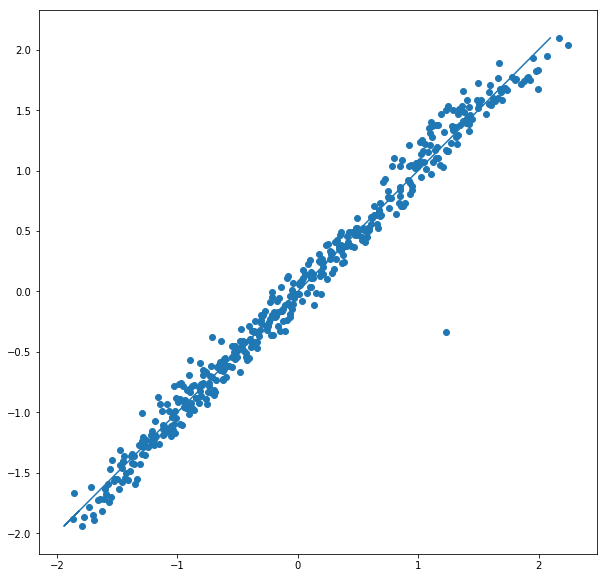

In [32]:
plt.figure(figsize=(10,10))
plt.plot(y,y)
plt.scatter(x, y)
plt.show
print('MSE:',cost.item())
print('RMSE:', np.sqrt(cost.item()))
# print('Percentage error:', (np.exp(np.sqrt(cost.item()))-1)*100,'%')